<a href="https://colab.research.google.com/github/vmanne20/MLB-PLayer-Value-Predictor/blob/master/ManneKanuri_FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### ECON 4984 Final Project - Predicting Wins Above Replacement (WAR) for MLB Batters

Authors: Vamsi Manne, Aditya Kanuri

Date: December 17, 2019



In [0]:
# Install a Python package, pybaseball, for importing MLB datasets
!pip install pybaseball

## Data Preprocessing

In [0]:
from pybaseball import batting_stats
import numpy as np
from pandas import DataFrame
from pandas import concat	
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np 
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
from matplotlib import pyplot as plt
import numpy as np

from math import sqrt
from numpy import concatenate
from sklearn.metrics import mean_squared_error

We removed duplicate records, kept players who played in each of the five seasons (so that a player record wouldn't be missing for a particular year), and dropped unqualified columns (missing values, not a float type). 

In [0]:
df = batting_stats(2015, 2019).sort_values(['Name', 'Season'])
df.to_csv('batting_data_original.csv', encoding='utf-8')

In [0]:

# find and remove all players with duplicate seasons
duplicate_players = df[df.duplicated(['Season', 'Name'])].Name
df2 = df[~df.Name.isin(duplicate_players)]

# keep players who played all 5 years
name_counts = df2.Name.value_counts()
batting_data = df2[df2.Name.isin(name_counts.index[name_counts.eq(5)])]
print(batting_data.shape)

# select valid statistics/columns (float64 dtype, no missing values)
stat_cols = batting_data.columns.values.tolist()
primary_cols = ['Name', 'Team']
for i in stat_cols:
    if batting_data[i].isnull().values.any() or (i not in primary_cols and batting_data[i].dtype != np.float64):
        batting_data.drop(i, axis=1, inplace=True)

batting_data.to_csv('batting_data_15-19.csv', encoding='utf-8')
batting_data.head()

(1670, 287)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Season,Name,Team,Age,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Rep,Pos,RAR,WAR,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,PH,WPA/LI,Z-Swing%,Swing%,Zone%,SwStr%,BsR,Def,wSB,Off,Lg,TTO%
391,2015.0,A.J. Pollock,Diamondbacks,27.0,157.0,609.0,673.0,192.0,127.0,39.0,6.0,20.0,111.0,76.0,53.0,0.0,89.0,2.0,9.0,0.0,19.0,39.0,7.0,0.315,264.0,152.0,109.0,14.0,2361.0,831.0,1530.0,19.0,4.0,4.0,0.079,0.132,0.60,0.367,0.498,0.865,0.182,0.338,0.0174,0.208,0.503,0.290,0.092,0.132,0.072,1.0,0.371,31.0,107.0,24.3,19.7,2.2,63.8,6.8,7.1,131.0,3.02,-11.51,14.53,30.98,3.17,0.99,7.0,3.62,0.640,0.460,0.467,0.069,6.7,11.9,4.7,31.0,1.1,0.241
1458,2016.0,A.J. Pollock,Diamondbacks,28.0,12.0,41.0,46.0,10.0,8.0,0.0,0.0,2.0,9.0,4.0,5.0,0.0,8.0,0.0,0.0,0.0,1.0,4.0,0.0,0.244,14.0,16.0,3.0,1.0,158.0,62.0,96.0,1.0,0.0,0.0,0.109,0.174,0.63,0.326,0.390,0.716,0.146,0.258,0.0088,0.091,0.424,0.485,0.063,0.125,0.071,0.0,0.315,-0.1,5.0,-0.6,1.4,0.1,4.4,0.4,7.0,89.0,0.38,-0.62,1.00,0.96,0.06,0.91,0.0,0.12,0.567,0.363,0.427,0.057,1.3,2.3,0.8,0.6,0.0,0.326
858,2017.0,A.J. Pollock,Diamondbacks,29.0,112.0,425.0,466.0,113.0,60.0,33.0,6.0,14.0,73.0,49.0,35.0,1.0,71.0,6.0,0.0,0.0,8.0,20.0,6.0,0.266,157.0,113.0,82.0,14.0,1739.0,637.0,1102.0,10.0,2.0,0.0,0.075,0.152,0.49,0.330,0.471,0.801,0.205,0.291,0.0139,0.233,0.446,0.321,0.124,0.124,0.064,0.0,0.340,7.6,64.0,1.6,14.4,1.4,22.1,2.2,7.5,103.0,0.06,-8.94,9.00,4.96,0.51,1.05,9.0,0.28,0.604,0.423,0.459,0.070,2.6,2.6,1.2,4.2,0.9,0.258
907,2018.0,A.J. Pollock,Diamondbacks,30.0,113.0,413.0,460.0,106.0,59.0,21.0,5.0,21.0,61.0,65.0,31.0,2.0,100.0,8.0,7.0,1.0,6.0,13.0,2.0,0.257,135.0,123.0,62.0,10.0,1720.0,605.0,1115.0,10.0,1.0,0.0,0.067,0.217,0.31,0.316,0.484,0.800,0.228,0.284,0.0110,0.194,0.422,0.384,0.081,0.171,0.074,0.0,0.338,8.7,62.0,6.0,13.8,1.6,25.3,2.6,6.7,111.0,1.51,-8.73,10.24,9.30,0.94,1.10,5.0,1.34,0.673,0.481,0.430,0.107,3.9,0.9,1.6,9.9,0.7,0.330
1024,2019.0,A.J. Pollock,Dodgers,31.0,86.0,308.0,342.0,82.0,51.0,15.0,1.0,15.0,49.0,47.0,23.0,1.0,74.0,7.0,4.0,0.0,7.0,5.0,1.0,0.266,103.0,87.0,47.0,11.0,1250.0,453.0,797.0,8.0,1.0,0.0,0.067,0.216,0.31,0.327,0.468,0.795,0.201,0.300,0.0118,0.198,0.435,0.367,0.126,0.172,0.078,0.0,0.333,3.8,47.0,3.6,10.8,0.0,9.4,0.9,4.9,108.0,0.89,-5.71,6.60,4.37,0.54,1.01,8.0,0.20,0.671,0.466,0.422,0.114,1.9,-7.2,0.4,5.5,0.3,0.328


We have 287 total predictors, and these are all batting metrics. Some of the popular metrics used to analyze performance are Hits (H), Runs (R), Runs Batted In (RBI), Walks (BB), On Base Percentage (OBP), and Batting Average (AVG). 

## Data Description

In [0]:
batting_data.describe()

,Season,Age,G,AB,PA,H,1B,2B,3B,HR,R,RBI,BB,IBB,SO,HBP,SF,SH,GDP,SB,CS,AVG,GB,FB,LD,IFFB,Pitches,Balls,Strikes,IFH,BU,BUH,BB%,K%,BB/K,OBP,SLG,OPS,ISO,BABIP,GB/FB,LD%,GB%,FB%,IFFB%,HR/FB,IFH%,BUH%,wOBA,wRAA,wRC,Bat,Rep,Pos,RAR,WAR,Spd,wRC+,WPA,-WPA,+WPA,RE24,REW,pLI,PH,WPA/LI,Z-Swing%,Swing%,Zone%,SwStr%,BsR,Def,wSB,Off,Lg,TTO%
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,2017.000000,28.374251,91.613772,298.883234,334.583234,77.627545,49.517964,15.473653,1.525150,11.110778,41.229341,39.596407,28.757485,1.855689,69.151497,3.269461,2.267066,1.332934,6.669461,4.835928,1.784431,0.223823,100.417365,81.344910,48.301198,7.896407,1298.718563,475.920958,822.797605,6.600599,3.252695,0.936527,0.073802,0.252759,0.362335,0.285434,0.361600,0.647028,0.137775,0.274866,0.017173,0.198422,0.466449,0.323159,0.097951,0.108180,0.059294,0.172498,0.279377,2.451497,42.253293,1.049701,10.148862,0.427186,13.177425,1.342335,3.262515,71.849102,0.209976,-5.760126,5.970012,3.447695,0.352150,0.966713,6.582036,0.304719,0.657423,0.466513,0.453899,0.112898,0.079641,1.079701,0.055210,1.125210,0.822994,0.352044
std,1.414637,3.529478,51.195322,210.808160,236.255044,60.174434,38.926833,12.707106,2.121595,11.183220,33.493131,33.183550,25.663103,3.101655,48.109949,3.950468,2.392680,2.222076,5.954669,7.980618,2.518999,0.088409,75.987173,63.973947,37.457797,7.577088,924.491629,353.372282,576.555249,6.260885,4.775447,1.921976,0.045667,0.135634,0.252753,0.102110,0.159359,0.254189,0.087064,0.104137,0.018791,0.091836,0.157725,0.130977,0.109913,0.089607,0.050677,0.283548,0.105143,13.939982,37.241088,13.349930,7.166268,4.974073,18.441787,1.874741,2.067427,68.827047,1.461971,4.002079,4.717939,15.420796,1.582247,0.155123,10.149047,1.469051,0.095297,0.066831,0.060110,0.051746,2.654782,7.342054,0.962636,13.723926,0.770563,0.129657
min,2015.000000,20.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-32.300000,-6.000000,-35.000000,0.000000,-16.000000,-31.000000,-3.200000,0.100000,-100.000000,-4.170000,-13.720000,0.000000,-34.530000,-3.390000,0.000000,0.000000,-3.150000,0.000000,0.000000,0.167000,0.000000,-11.100000,-22.400000,-2.800000,-36.600000,0.000000,0.000000
25%,2016.000000,26.000000,34.000000,65.000000,72.000000,13.000000,9.000000,2.000000,0.000000,1.000000,6.000000,6.000000,4.000000,0.000000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.200000,22.250000,13.250000,9.000000,1.000000,268.250000,91.000000,183.250000,1.000000,0.000000,0.000000,0.047000,0.176000,0.200000,0.259000,0.293000,0.564250,0.081000,0.250000,0.009800,0.173000,0.389000,0.273250,0.041000,0.034000,0.028000,0.000000,0.250000,-6.200000,4.000000,-7.000000,2.200000,-1.500000,-0.300000,0.000000,1.600000,50.000000,-0.650000,-9.390000,0.832500,-6.062500,-0.620000

From the data summary above, we can see that some metrics have large standard deviations and the data varies a lot. This is because some players may have only played a couple games during the season for all 5 seasons, and other players consistently showed up. The observations with very few games are outliers, but we decided not to remove them because we want to predict the WAR for all players in that time period. If a player is injured for most of each season, his WAR would obviously be very low and teams would not consider him since he is injury-prone and would not contribute much to the team.

Some key metrics that people use are Batting Average (BA), Runs Batted In (RBI), and Home Runs. We decided to use many metrics because a few stats don't tell the whole story about a player's performance, and we wanted to factor in as many inputs as we can to build the best model for predicting WAR. 

## Determining Correlation Between Variables

We generated a correlation heatmap and scatter plots to show how closely predictors are correlated with each other. These can be used to explain common trends, and guage the effect of some variables on the target.

Since it is not feasible to plot the correlation between all 287 predictors, we chose a subset containing the most common metrics used in baseball. This will include all the columns from the beginning up to the "BABIP" metric.

(1670, 43)


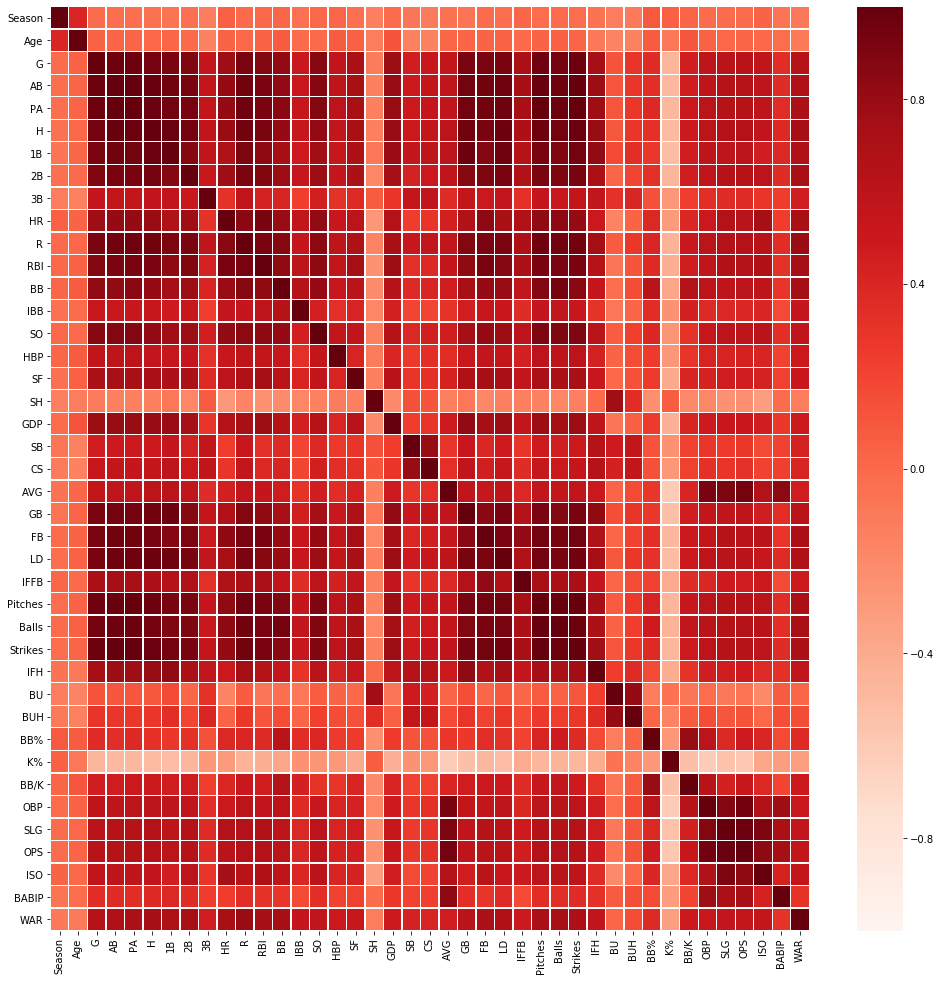

In [0]:
import seaborn as sns

# choose subset of most common predictors
stat_cols = batting_data.columns.values.tolist()
col_count = 0
for col in stat_cols:
    col_count += 1
    if col == 'BABIP':
        break

subset = batting_data.iloc[:,:col_count]
subset['WAR'] = batting_data['WAR']
print(subset.shape)

# Display correlation heatmap
corr = subset.corr()
plt.figure(figsize=(17,17))
sns.heatmap(corr, annot=False, linewidth=0.3, center=0, cmap='Reds', vmin=-1)

Our new subset of predictors contains 42 metrics. From the correlation heatmap above, we can see that hitting-related metrics such as number of hits (H), singles (1B), doubles (2B), home runs (HR), and runs batted in (RBI) are positively correlated with games and plate appearances. This makes sense because players who play more will accumulate more of those statistics. 

We can also see that strikeout percentage (K%) is negatively correlated with hitting and on-base metrics (OBP, OPS, BABIP). On-base metrics indicate the tendency of players to get on base and move the chains for the rest of the offense. It has a transitive effect on scoring runs. This correlation makes sense since players who get on base a lot usually avoid striking out. 

There are no metrics that have a really high correlation with the target variable, WAR. Metrics such as H, RBI, and OPS have some of the strongest positive correlations with WAR. 

We displayed a couple correlation scatter plots to see the the relationship between a pair of metrics. 

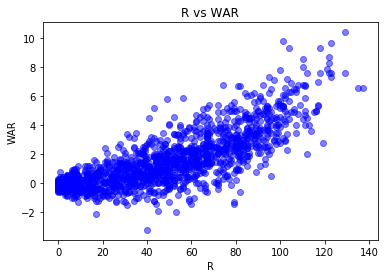

In [0]:
plt.scatter(batting_data['R'], batting_data['WAR'], c='blue', alpha=0.5)
plt.title('R vs WAR')
plt.xlabel('R')
plt.ylabel('WAR')
plt.show()

Players who score more runs tend to have a higher WAR. This is because when they produce more offense, they contribute more to the team and "add" more wins to the team's projected wins. 

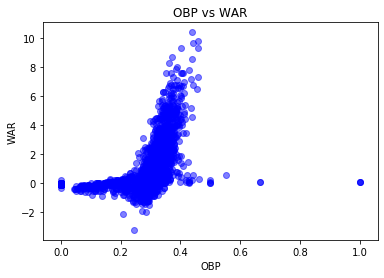

In [0]:
plt.scatter(batting_data['OBP'], batting_data['WAR'], c='blue', alpha=0.5)
plt.title('OBP vs WAR')
plt.xlabel('OBP')
plt.ylabel('WAR')
plt.show()

OBP means On-Base Percentage. This metric measures how often a player gets on base (either a hit or a walk) in their plate appearances. Players with higher on-base percentages usually have higher WAR since they contribute more to run production.

There are a couple outliers, where players have an on-base percentage of over 0.5. This is very uncommon and those players only played a couple games. Their WARs are around 0 because they didn't play for most of the season, and the sample size for plate appearances from which the OBP is calculated is very small.

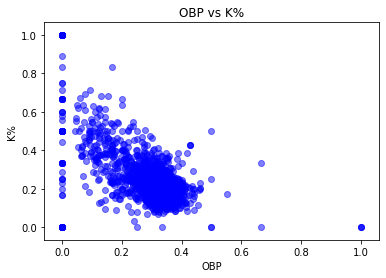

In [0]:
plt.scatter(batting_data['OBP'], batting_data['K%'], c='blue', alpha=0.5)
plt.title('OBP vs K%')
plt.xlabel('OBP')
plt.ylabel('K%')
plt.show()

Players who get on base frequently tend to strike out less. That is why there is a negative correlation between OBP and strikeout percentage (K%).

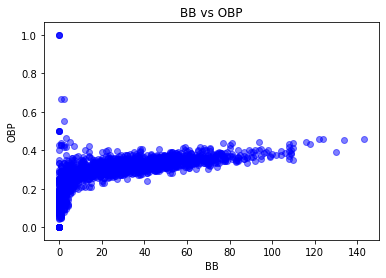

In [0]:
plt.scatter(batting_data['BB'], batting_data['OBP'], c='blue', alpha=0.5)
plt.title('BB vs OBP')
plt.xlabel('BB')
plt.ylabel('OBP')
plt.show()

There is a positive correlation between Walks (BB) and OBP. This is obvious because if a player gets more walks, he is on base more.

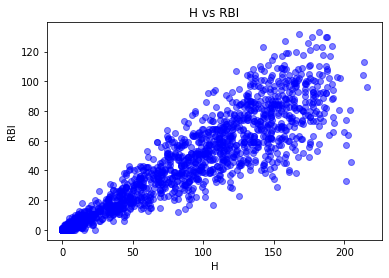

In [0]:
plt.scatter(batting_data['H'], batting_data['RBI'], c='blue', alpha=0.5)
plt.title('H vs RBI')
plt.xlabel('H')
plt.ylabel('RBI')
plt.show()

There is a strong positive correlation between Hits and Runs Batted In (RBI) because players who get more hits can drive in runs if other players are already on base.

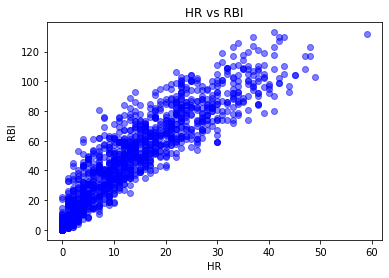

In [0]:
plt.scatter(batting_data['HR'], batting_data['RBI'], c='blue', alpha=0.5)
plt.title('HR vs RBI')
plt.xlabel('HR')
plt.ylabel('RBI')
plt.show()

Players who hit more home runs also drive in a lot of runs since a home run will score all players on base.

##Time Series with LSTM Model

First, we split the dataset into input and output sets. Then we standardize the data and split them into train and test sets.

In [0]:

df1 = batting_data
print(df1.head)
new_df1 = df1
for x in df1.columns:
  if ("Name" in x or "Team" in x ):
    new_df1 = new_df1.drop(x, 1)

# generate input (X) and target (Y) DataFrames
x_df = new_df1
y_df = new_df1
for x in new_df1.columns:
  if "WAR" not in x:
    y_df = y_df.drop(x, 1)
  else:
    x_df = x_df.drop(x, 1)

# standardize the data
scaler = StandardScaler()
scaledx = scaler.fit_transform(x_df.values)
scaledy = scaler.fit_transform(y_df.values)
print(x_df)
print(y_df)

# split into train and test sets
years = (334 * 4) - 1
x_train = scaledx[:years, :]
y_train = scaledy[:years, :]
x_test = scaledx[years:, :]
y_test = scaledy[years:, :]

print(x_train.shape)
print(y_train)
print(x_test)
print(y_test)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 3
batch_size1 = 1330
train_generator = TimeseriesGenerator(x_train, y_train, length=timesteps, sampling_rate=1, batch_size=batch_size1)
test_generator = TimeseriesGenerator(x_test, y_test, length=timesteps, sampling_rate=1, batch_size=batch_size1)





<bound method NDFrame.head of       Season          Name          Team   Age  ...  wSB   Off   Lg   TTO%
391   2015.0  A.J. Pollock  Diamondbacks  27.0  ...  4.7  31.0  1.1  0.241
1458  2016.0  A.J. Pollock  Diamondbacks  28.0  ...  0.8   0.6  0.0  0.326
858   2017.0  A.J. Pollock  Diamondbacks  29.0  ...  1.2   4.2  0.9  0.258
907   2018.0  A.J. Pollock  Diamondbacks  30.0  ...  1.6   9.9  0.7  0.330
1024  2019.0  A.J. Pollock       Dodgers  31.0  ...  0.4   5.5  0.3  0.328
...      ...           ...           ...   ...  ...  ...   ...  ...    ...
2777  2015.0  Zack Greinke       Dodgers  31.0  ...  0.2  -3.8  0.1  0.221
3106  2016.0  Zack Greinke  Diamondbacks  32.0  ...  0.2  -5.8  0.1  0.200
2942  2017.0  Zack Greinke  Diamondbacks  33.0  ...  0.0  -6.3  0.1  0.286
2747  2018.0  Zack Greinke  Diamondbacks  34.0  ...  0.6  -3.6  0.1  0.268
499   2019.0  Zack Greinke         - - -  35.0  ... -0.3   1.4  0.1  0.304

[1670 rows x 78 columns]>
      Season   Age      G     AB     PA  ..

In [0]:
#print(len(train_generator[0]))
train_x1, train_y1 = train_generator[0]
test_x1, test_y1 = test_generator[0]

print(train_y1.shape)
print(train_x1.shape)
print(test_y1.shape)
print(test_x1.shape)


(1330, 1)
(1330, 3, 75)
(332, 1)
(332, 3, 75)


We run an LSTM Model with a Leaky ReLU activation function.

In [0]:

model = Sequential()
model.add(LSTM(50, input_shape=(train_x1.shape[1], train_x1.shape[2])))
model.add(LeakyReLU(alpha=0.5)) 
model.add(Dropout(0.1))
model.add(Dense(1))


model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_generator, epochs=120, validation_data=test_generator, verbose=2, shuffle=False)




Epoch 1/120
 - 2s - loss: 0.7588 - val_loss: 0.5994
Epoch 2/120
 - 0s - loss: 0.6376 - val_loss: 0.6048
Epoch 3/120
 - 0s - loss: 0.6215 - val_loss: 0.6148
Epoch 4/120
 - 0s - loss: 0.6144 - val_loss: 0.6160
Epoch 5/120
 - 0s - loss: 0.6077 - val_loss: 0.6068
Epoch 6/120
 - 0s - loss: 0.5910 - val_loss: 0.5931
Epoch 7/120
 - 0s - loss: 0.5656 - val_loss: 0.5812
Epoch 8/120
 - 0s - loss: 0.5554 - val_loss: 0.5741
Epoch 9/120
 - 0s - loss: 0.5518 - val_loss: 0.5711
Epoch 10/120
 - 0s - loss: 0.5590 - val_loss: 0.5690
Epoch 11/120
 - 0s - loss: 0.5386 - val_loss: 0.5662
Epoch 12/120
 - 0s - loss: 0.5264 - val_loss: 0.5633
Epoch 13/120
 - 0s - loss: 0.5369 - val_loss: 0.5604
Epoch 14/120
 - 0s - loss: 0.5228 - val_loss: 0.5577
Epoch 15/120
 - 0s - loss: 0.5181 - val_loss: 0.5553
Epoch 16/120
 - 0s - loss: 0.5110 - val_loss: 0.5526
Epoch 17/120
 - 0s - loss: 0.5078 - val_loss: 0.5498
Epoch 18/120
 - 0s - loss: 0.5088 - val_loss: 0.5471
Epoch 19/120
 - 0s - loss: 0.4968 - val_loss: 0.5448
Ep

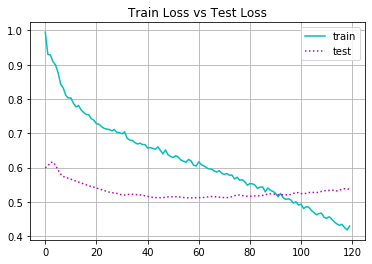

In [0]:
#Plot loss function
plt.plot(history.history['loss'], 'c-', label='train')
plt.plot(history.history['val_loss'], 'm:', label='test')
plt.title("Train Loss vs Test Loss")
plt.legend()
plt.grid(True)
plt.show()

In [0]:
pred = model.predict(test_x1)
print(test_x1.shape)
test_x1_reshaped = test_x1.reshape((test_x1.shape[0], test_x1.shape[2]*timesteps))
print(test_x1_reshaped.shape)
print(pred.shape)

# invert scaling for predicted
yhat = concatenate((pred, test_x1_reshaped[:, 1:]), axis=1)
yhat = scaler.inverse_transform(yhat)
yhat = yhat[:,0]

# invert scaling to get actual data
test_y1_reshaped = test_y1.reshape((len(test_y1), 1))
act_y = concatenate((test_y1_reshaped, test_x1_reshaped[:, 1:]), axis=1)
act_y = scaler.inverse_transform(act_y)
act_y = act_y[:,0]

#calculate RMSE
rmse = sqrt(mean_squared_error(test_y1, pred))
rmse1 = sqrt(mean_squared_error(act_y, yhat))
print('Test scaled RMSE: ' + str(rmse))
print('Test regular RMSE: ' + str(rmse1))


(332, 3, 75)
(332, 225)
(332, 1)
Test scaled RMSE: 0.732759353322913
Test regular RMSE: 1.3733226051594616


In [0]:
#model 2 w/ war as input
print(new_df1)

      Season   Age      G     AB     PA  ...   Def  wSB   Off   Lg   TTO%
391   2015.0  27.0  157.0  609.0  673.0  ...  11.9  4.7  31.0  1.1  0.241
1458  2016.0  28.0   12.0   41.0   46.0  ...   2.3  0.8   0.6  0.0  0.326
858   2017.0  29.0  112.0  425.0  466.0  ...   2.6  1.2   4.2  0.9  0.258
907   2018.0  30.0  113.0  413.0  460.0  ...   0.9  1.6   9.9  0.7  0.330
1024  2019.0  31.0   86.0  308.0  342.0  ...  -7.2  0.4   5.5  0.3  0.328
...      ...   ...    ...    ...    ...  ...   ...  ...   ...  ...    ...
2777  2015.0  31.0   32.0   67.0   77.0  ...   8.0  0.2  -3.8  0.1  0.221
3106  2016.0  32.0   27.0   52.0   60.0  ...   6.5  0.2  -5.8  0.1  0.200
2942  2017.0  33.0   33.0   62.0   70.0  ...   8.3  0.0  -6.3  0.1  0.286
2747  2018.0  34.0   34.0   64.0   71.0  ...   8.6  0.6  -3.6  0.1  0.268
499   2019.0  35.0   36.0   50.0   56.0  ...   6.9 -0.3   1.4  0.1  0.304

[1670 rows x 76 columns]


In [0]:
new_df2 = new_df1


x_df1 = new_df2
y_df1= new_df2
for x in new_df2.columns:
  if "WAR" not in x:
    y_df1 = y_df1.drop(x, 1)

scaler1 = StandardScaler()
scaledx1 = scaler1.fit_transform(x_df1.values)
scaledy1 = scaler1.fit_transform(y_df1.values)
print(x_df1.shape)
print(y_df1)

# split into train and test sets
years = (334 * 4) - 1
x_train1 = scaledx1[:years, :]
y_train1 = scaledy1[:years, :]
x_test1 = scaledx1[years:, :]
y_test1 = scaledy1[years:, :]

print(x_train1.shape)
print(y_train1)
print(x_test1)
print(y_test1)

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 3
batch_size1 = 1330
train_generator1 = TimeseriesGenerator(x_train1, y_train1, length=timesteps, sampling_rate=1, batch_size=batch_size1)
test_generator1 = TimeseriesGenerator(x_test1, y_test1, length=timesteps, sampling_rate=1, batch_size=batch_size1)

(1670, 76)
      WAR
391   6.8
1458  0.4
858   2.2
907   2.6
1024  0.9
...   ...
2777  0.7
3106  0.3
2942  0.4
2747  0.7
499   1.0

[1670 rows x 1 columns]
(1335, 76)
[[ 2.9120287 ]
 [-0.50279885]
 [ 0.4576214 ]
 ...
 [-0.76958225]
 [-1.08972233]
 [-0.44944217]]
[[-1.41421356 -0.10606769  0.49601859 ... -0.70155526 -0.54910611
   0.09224265]
 [-0.70710678  0.17734518  0.61325191 ... -0.63595672 -0.54910611
  -0.44009173]
 [ 0.          0.46075806  0.16385754 ... -0.49018217 -0.15966364
  -0.05434218]
 ...
 [ 0.          1.31099669 -1.14524779 ... -0.54120326 -0.93854859
  -0.50952665]
 [ 0.70710678  1.59440956 -1.12570891 ... -0.34440763 -0.93854859
  -0.64839648]
 [ 1.41421356  1.87782244 -1.08663114 ...  0.02002872 -0.93854859
  -0.37065681]]
[[-0.82293893]
 [-0.60951221]
 [-0.55615553]
 [-0.76958225]
 [-0.98300897]
 [-0.18265877]
 [-0.44944217]
 [-1.08972233]
 [-0.76958225]
 [-0.76958225]
 [-0.82293893]
 [-0.76958225]
 [-0.66286889]
 [-0.71622557]
 [-0.71622557]
 [-0.18265877]
 [ 0.

In [0]:
train_x2, train_y2 = train_generator1[0]
test_x2, test_y2 = test_generator1[0]

print(train_y2.shape)
print(train_x2.shape)
print(test_y2.shape)
print(test_x2.shape)

(1330, 1)
(1330, 3, 76)
(332, 1)
(332, 3, 76)


In [0]:
model1 = Sequential()
model1.add(LSTM(50, input_shape=(train_x2.shape[1], train_x2.shape[2])))
model1.add(LeakyReLU(alpha=0.5)) 
model1.add(Dropout(0.1))
model1.add(Dense(1))


model1.compile(loss='mse', optimizer='adam')
# fit network
history1 = model1.fit(train_generator1, epochs=120, validation_data=test_generator1, verbose=2, shuffle=False)


Epoch 1/120
 - 2s - loss: 0.8448 - val_loss: 0.5834
Epoch 2/120
 - 0s - loss: 0.6990 - val_loss: 0.5705
Epoch 3/120
 - 0s - loss: 0.6928 - val_loss: 0.5756
Epoch 4/120
 - 0s - loss: 0.6375 - val_loss: 0.5767
Epoch 5/120
 - 0s - loss: 0.6475 - val_loss: 0.5736
Epoch 6/120
 - 0s - loss: 0.6117 - val_loss: 0.5698
Epoch 7/120
 - 0s - loss: 0.6189 - val_loss: 0.5685
Epoch 8/120
 - 0s - loss: 0.5814 - val_loss: 0.5682
Epoch 9/120
 - 0s - loss: 0.5768 - val_loss: 0.5677
Epoch 10/120
 - 0s - loss: 0.5626 - val_loss: 0.5666
Epoch 11/120
 - 0s - loss: 0.5552 - val_loss: 0.5649
Epoch 12/120
 - 0s - loss: 0.5460 - val_loss: 0.5627
Epoch 13/120
 - 0s - loss: 0.5461 - val_loss: 0.5597
Epoch 14/120
 - 0s - loss: 0.5368 - val_loss: 0.5561
Epoch 15/120
 - 0s - loss: 0.5314 - val_loss: 0.5525
Epoch 16/120
 - 0s - loss: 0.5328 - val_loss: 0.5491
Epoch 17/120
 - 0s - loss: 0.5165 - val_loss: 0.5460
Epoch 18/120
 - 0s - loss: 0.5187 - val_loss: 0.5432
Epoch 19/120
 - 0s - loss: 0.5208 - val_loss: 0.5408
Ep

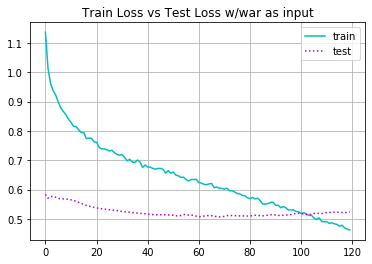

In [0]:
plt.plot(history1.history['loss'], 'c-', label='train')
plt.plot(history1.history['val_loss'], 'm:', label='test')
plt.title("Train Loss vs Test Loss w/war as input")
plt.legend()
plt.grid(True)
plt.show()

In [0]:
pred1 = model1.predict(test_x2)
print(test_x2.shape)
test_x2_reshaped = test_x2.reshape((test_x2.shape[0], test_x2.shape[2]*timesteps))
print(test_x2_reshaped.shape)
print(pred1.shape)
# invert scaling for forecast
yhat1 = concatenate((pred1, test_x2_reshaped[:, 1:]), axis=1)
yhat1 = scaler.inverse_transform(yhat1)
yhat1 = yhat1[:,0]
# invert scaling for actual
test_y2_reshaped = test_y2.reshape((len(test_y2), 1))
act_y1 = concatenate((test_y2_reshaped, test_x2_reshaped[:, 1:]), axis=1)
act_y1 = scaler1.inverse_transform(act_y1)
act_y1 = act_y1[:,0]
#calculate RMSE
rmse2 = sqrt(mean_squared_error(test_y2, pred1))
rmse3 = sqrt(mean_squared_error(act_y1, yhat1))
print('Test scaled RMSE: ' +  str(rmse2))
print('Test regular RMSE: ' + str(rmse3))
#print(pred)

(332, 3, 76)
(332, 228)
(332, 1)
Test scaled RMSE: 0.7233739188582704
Test regular RMSE: 1.3557326156887213


## WAR Predictions for 2020

We used our LSTM model to make WAR predictions for each player in the 2020 season. We also displayed the players with the highest projected WARs. This will be useful to teams that are evaluating the best players on the market, and fans who need to add players to their fantasy baseball team.

In [0]:
new_pred_df = batting_data
new_pred_df = new_pred_df[new_pred_df.Season != 2015]
new_pred_df = new_pred_df[new_pred_df.Season != 2016]
print(new_pred_df)

for x in new_pred_df.columns:
  if ("Name" in x or "Team" in x ):
    new_pred_df = new_pred_df.drop(x, 1)
    
x_df2 = new_pred_df
y_df2 = new_pred_df
for x in new_pred_df.columns:
  if "WAR" in x:
    x_df2 = x_df2.drop(x, 1)
  else :
    y_df2 = y_df2.drop(x, 1)

scaler2 = StandardScaler()
scaledx2 = scaler2.fit_transform(x_df2.values)
scaledy2 = scaler2.fit_transform(y_df2.values)

print(x_df2.shape)
print(y_df2.shape)

# split into train and test sets
x_train2 = scaledx2[:, :]
y_train2 = scaledy2[:, :]

# Create overlapping windows of lagged values for training and testing datasets
timesteps = 3
batch_size1 = 1330
train_generator2 = TimeseriesGenerator(x_train2, y_train2, length=timesteps, sampling_rate=1, batch_size=batch_size1)

      Season           Name          Team   Age  ...  wSB   Off   Lg   TTO%
858   2017.0   A.J. Pollock  Diamondbacks  29.0  ...  1.2   4.2  0.9  0.258
907   2018.0   A.J. Pollock  Diamondbacks  30.0  ...  1.6   9.9  0.7  0.330
1024  2019.0   A.J. Pollock       Dodgers  31.0  ...  0.4   5.5  0.3  0.328
538   2017.0  Aaron Altherr      Phillies  26.0  ... -0.9   8.5  0.8  0.376
2244  2018.0  Aaron Altherr      Phillies  27.0  ... -0.4 -10.4  0.4  0.474
...      ...            ...           ...   ...  ...  ...   ...  ...    ...
3781  2018.0    Zack Godley  Diamondbacks  28.0  ...  0.0 -12.1  0.1  0.523
3103  2019.0    Zack Godley         - - -  29.0  ...  0.0  -2.3  0.0  0.565
2942  2017.0   Zack Greinke  Diamondbacks  33.0  ...  0.0  -6.3  0.1  0.286
2747  2018.0   Zack Greinke  Diamondbacks  34.0  ...  0.6  -3.6  0.1  0.268
499   2019.0   Zack Greinke         - - -  35.0  ... -0.3   1.4  0.1  0.304

[1002 rows x 78 columns]
(1002, 75)
(1002, 1)


In [0]:
pred_datax, pred_datay= train_generator2[0]

pred2 = model.predict(pred_datax)
names = []
for x in batting_data["Name"]:
   if (x not in names):
     names.append(x)
act_pred2 = scaler1.inverse_transform(pred2)
for x in range(len(names)):
  print(names[x] + ":,  " + str(act_pred2[x][0])) 

A.J. Pollock:,  1.1745876
Aaron Altherr:,  2.0950294
Aaron Hicks:,  1.1790854
Aaron Nola:,  0.9602338
Abraham Almonte:,  2.589018
Adam Duvall:,  3.3213615
Adam Eaton:,  1.7228818
Adam Jones:,  0.026516542
Adam Wainwright:,  0.24094461
Addison Russell:,  0.6984661
Adeiny Hechavarria:,  1.0458887
Albert Pujols:,  0.86155796
Alex Avila:,  1.206285
Alex Gordon:,  2.1223273
Alex Wood:,  1.305323
Andrelton Simmons:,  1.8322926
Andrew Cashner:,  0.966582
Andrew McCutchen:,  0.5669497
Anibal Sanchez:,  1.8395293
Anthony Rendon:,  2.273378
Anthony Rizzo:,  1.1324639
Asdrubal Cabrera:,  -1.0130805
Austin Barnes:,  -0.31449962
Austin Hedges:,  -0.13850094
Austin Romine:,  0.42912263
Avisail Garcia:,  1.3595198
Ben Zobrist:,  1.494641
Billy Hamilton:,  1.3457264
Blake Swihart:,  1.0326304
Brad Miller:,  0.6781308
Brandon Belt:,  0.6280106
Brandon Crawford:,  -0.25778854
Brandon Drury:,  -0.698423
Brett Anderson:,  -0.6665951
Brett Gardner:,  1.3742465
Brian Dozier:,  1.2413269
Brian McCann:,  1.66